<a href="https://colab.research.google.com/github/simulate111/Data-Science_2024/blob/main/Mini%20Project%201%20%E2%80%93%20What%20should%20I%20cook%20tonight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from IPython.display import display, HTML

In [30]:
def scrape_recipe_details(link):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(link, headers=headers, timeout=10)
    soup = BeautifulSoup(response.text, 'html.parser')
    title = soup.select_one('.entry-title')
    image = soup.select_one('.wp-block-image img')
    ww_points = soup.select_one('.recipe-meta-value.recipe-ww-pp')

    recipe_titles = soup.select('ul.cat-icons.post-icons a')
    recipe_keys_list = [key['title'] for key in recipe_titles if 'title' in key.attrs]
    calories_container = soup.select_one('.wprm-nutrition-label-text-nutrition-container-calories')
    calories_value = (calories_container.select_one('.wprm-nutrition-label-text-nutrition-value').get_text(strip=True) if calories_container else "N/A")
    calories_value = int(calories_value) if calories_value.isdigit() else None

    title = title.get_text(strip=True) if title else "N/A"
    image_src = image['src'] if image else "N/A"
    points_value = (ww_points.get_text(strip=True) if ww_points else "N/A")
    points_value = int(points_value) if points_value.isdigit() else None
    return {'Name of the Food': title, 'Image of the Food': image_src, 'Calories': calories_value, 'Points': points_value, 'Recipe Keys': recipe_keys_list}

def scrapes(start_page, end_page):
    all_recipes = []
    base_url = 'https://www.skinnytaste.com/recipe-index/?_paged={}'

    for page in tqdm(range(start_page, end_page + 1), bar_format='{bar}| {n_fmt}/{total_fmt} pages', leave=False):
        url = base_url.format(page)
       #logging.debug(f"Scraping page: {url}")
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        recipe_links = [a['href'] for a in soup.select('.entry-title a')]
        for link in recipe_links:
            recipe_details = scrape_recipe_details(link)
            if recipe_details:
                all_recipes.append(recipe_details)

    return all_recipes

In [31]:
# Scrape the first xx pages
recipes = scrapes(1, 1)

In [32]:
df = pd.DataFrame(recipes)
display(df)

,Name of the Food,Image of the Food,Calories,Points,Recipe Keys
0,Free 7 Day Healthy Meal Plan (Sept 23-29),https://www.skinnytaste.com/wp-content/uploads...,NaN,NaN,[]
1,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,34.0,1.0,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."
2,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,177.0,4.0,"[Dairy Free Recipes, Gluten Free, Vegetarian M..."
3,Apple Bread,https://www.skinnytaste.com/wp-content/uploads...,124.0,4.0,[Vegetarian Meals]
4,Autumn Salad with Pears and Gorgonzola,https://www.skinnytaste.com/wp-content/uploads...,175.0,5.0,"[Gluten Free, Low Carb, Under 30 Minutes, Vege..."
5,Sesame Chicken,https://www.skinnytaste.com/wp-content/uploads...,513.0,9.0,"[Dairy Free Recipes, Freezer Meals, Gluten Fre..."
6,Bacon in the Oven,https://www.skinnytaste.com/wp-content/uploads...,60.0,2.0,"[Dairy Free Recipes, Gluten Free, High Protein..."
7,Pumpkin Spice Latte,https://www.skinnytaste.com/wp-content/uploads...,115.0,7.0,"[Dairy Free Recipes, Gluten Free, Vegetarian M..."
8,Homemade Hamburger Helper,https://www.skinnytaste.com/wp-content/uploads...,453.0,12.0,"[Dairy Free Recipes, Gluten Free, High Protein..."
9,Fried Brown Rice,https://www.skinnytaste.com/wp-content/uploads...,276.0,6.0,"[Dairy Free Recipes, Gluten Free, High-Fiber R..."


Text(0, 0.5, 'Count')

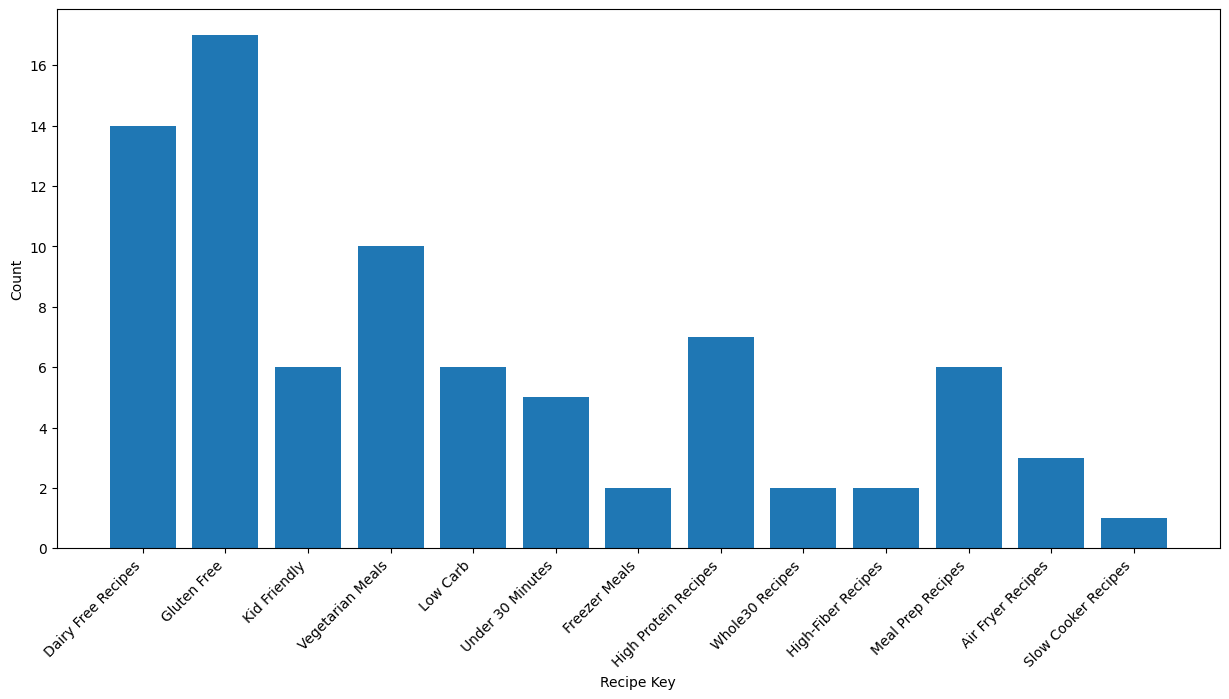

In [33]:
all_recipe_keys = [key for sublist in df['Recipe Keys'] for key in sublist]
key_counts = Counter(all_recipe_keys)
key_counts_df = pd.DataFrame(key_counts.items(), columns=['Recipe Key', 'Count'])
plt.figure(figsize=(15, 7))
plt.bar(key_counts_df['Recipe Key'], key_counts_df['Count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Recipe Key')
plt.ylabel('Count')

Text(0, 0.5, 'Frequency')

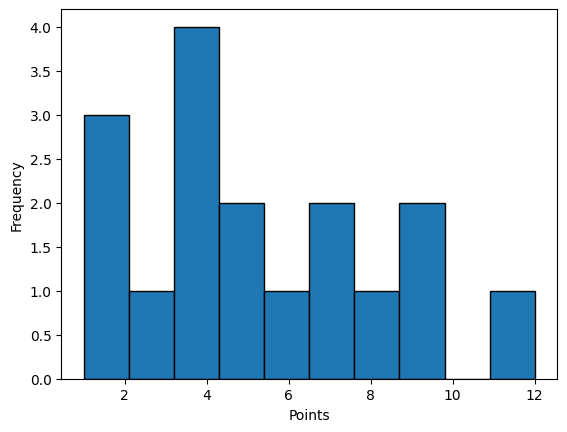

In [34]:
plt.hist(df['Points'], bins=10, edgecolor='black')
plt.xlabel('Points')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

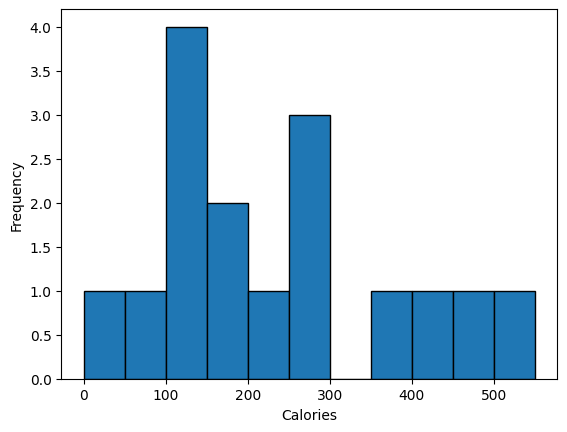

In [35]:
plt.hist(df['Calories'], bins=range(0, int(df['Calories'].max()) + 50, 50), edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')

In [37]:
def filters(df):
    max_points = df['Points'].max()
    min_points = df['Points'].min()
    max_calories = df['Calories'].max()
    min_calories = df['Calories'].min()
    print(f"Maximum Points: {max_points}")
    print(f"Minimum Points: {min_points}")
    print(f"Maximum Calories: {max_calories}")
    print(f"Minimum Calories: {min_calories}")
    print("Which range of calories and points do you like to be suggested?")

    calorie_min = int(input("Enter minimum calories: "))
    calorie_max = int(input("Enter maximum calories: "))
    point_min = int(input("Enter minimum points: "))
    point_max = int(input("Enter maximum points: "))
    filtered_df = df[(df['Calories'] >= calorie_min) & (df['Calories'] <= calorie_max) & (df['Points'] >= point_min) & (df['Points'] <= point_max)]

    # Sort by calories
    sorted_recipes = filtered_df.sort_values(by='Calories').head(10).reset_index(drop=True)

    if not sorted_recipes.empty:
        sorted_recipes['Image of the Food'] = sorted_recipes['Image of the Food'].apply(lambda x: f'<img src="{x}" width="150" />' )
        display(HTML(sorted_recipes[['Name of the Food', 'Calories', 'Points', 'Image of the Food', 'Recipe Keys']].to_html(escape=False)))
    else:
        print("No recipes found in the specified range.")

filters(df)

Maximum Points: 12.0
Minimum Points: 1.0
Maximum Calories: 513.0
Minimum Calories: 34.0
Which range of calories and points do you like to be suggested?
Enter minimum calories: 11
Enter maximum calories: 55
Enter minimum points: 2
Enter maximum points: 4
No recipes found in the specified range.
